In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

## ПОДГОТОВКА ДАННЫХ

In [85]:
N_STUDENT = 9

drive.mount('/content/drive')

try:
    df = pd.read_csv('/content/drive/My Drive/famcs_students.csv')
except FileNotFoundError:
    print("Файл не найден. Пожалуйста, загрузите 'famcs_students.csv' в среду Colab.")

binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target_col = binary_cols[N_STUDENT % 8]

print(f"Целевая переменная (y): {target_col}")

raw_y = df[target_col].values

le = LabelEncoder()
y = le.fit_transform(raw_y)
print(f"Классы '{le.classes_[0]}' и '{le.classes_[1]}' заменены на 0 и 1.")

feature_cols = [c for c in df.columns if c != target_col and pd.api.types.is_numeric_dtype(df[c])]

X = df[feature_cols].values

X = np.nan_to_num(X)

print(f"Признаки (X): {feature_cols}")

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1
X = (X - X_mean) / X_std

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Размеры выборок: Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Целевая переменная (y): interest
Классы 'Математика' и 'Программирование' заменены на 0 и 1.
Признаки (X): ['cource', 'group', 'age', 'height', 'miss', 'foot_size', 'score']
Размеры выборок: Train: (88, 7), Val: (19, 7), Test: (20, 7)


## 0. ТРИВИАЛЬНЫЙ КЛАССИФИКАТОР

In [86]:
class TrivialClassifier:
    def fit(self, y):
        vals, counts = np.unique(y, return_counts=True)
        self.majority_class = vals[np.argmax(counts)]

    def predict(self, X):
        return np.full(X.shape[0], self.majority_class)


## 1. НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР

In [87]:
class CustomNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.params = {}
        self.var_smoothing = np.var(X, axis=0).max() * 1e-1

        for c in self.classes:
            X_c = X[y == c]
            self.params[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + self.var_smoothing,
                'prior': X_c.shape[0] / X.shape[0]
            }

    def _pdf(self, class_idx, x):
        mean = self.params[class_idx]['mean']
        var = self.params[class_idx]['var']
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.params[c]['prior'])
                pdf_val = self._pdf(c, x)
                likelihood = np.sum(np.log(pdf_val + 1e-10))
                posteriors.append(likelihood + prior)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)

    def predict_proba(self, X):
        probs = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.params[c]['prior'])
                pdf_val = self._pdf(c, x)
                likelihood = np.sum(np.log(pdf_val + 1e-10))
                posteriors.append(likelihood + prior)
            posteriors = np.array(posteriors)
            exps = np.exp(posteriors - np.max(posteriors))
            probs.append(exps / np.sum(exps))

        if len(self.classes) == 2:
            return np.array(probs)[:, 1]
        else:
            return np.array(probs)[:, 0]

## 2. k-БЛИЖАЙШИХ СОСЕДЕЙ (k-NN)

In [88]:
class CustomKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            vals, counts = np.unique(k_nearest_labels, return_counts=True)
            y_pred.append(vals[np.argmax(counts)])
        return np.array(y_pred)

    def predict_proba(self, X):
        y_proba = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            y_proba.append(np.mean(k_nearest_labels))
        return np.array(y_proba)

## 3. ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [89]:
class CustomLogisticRegression:
    def __init__(self, lr=0.01, n_iters=1000, threshold=0.5):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.threshold = threshold

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X):
        y_predicted_cls = [1 if i > self.threshold else 0 for i in self.predict_proba(X)]
        return np.array(y_predicted_cls)

    def set_threshold(self, threshold):
        self.threshold = threshold

## 4. ОЦЕНКА КАЧЕСТВА

>>> Запуск Тривиального классификатора
--- Trivial Classifier ---
Accuracy:  0.8000
Precision: 0.8000
Recall:    1.0000
ROC-AUC:   0.5000


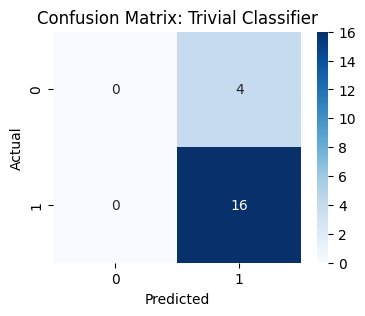



>>> Запуск Наивного Байеса
--- Naive Bayes ---
Accuracy:  0.8000
Precision: 0.8000
Recall:    1.0000
ROC-AUC:   0.3906


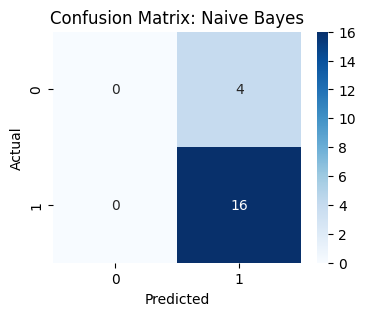



>>> Запуск k-NN с подбором k
Оптимальный k: 9
--- k-NN (k=9) ---
Accuracy:  0.8000
Precision: 0.8000
Recall:    1.0000
ROC-AUC:   0.4844


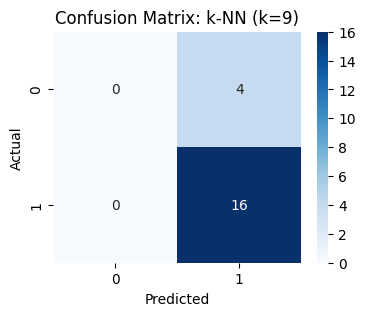



>>> Запуск Логистической регрессии с подбором Learning Rate


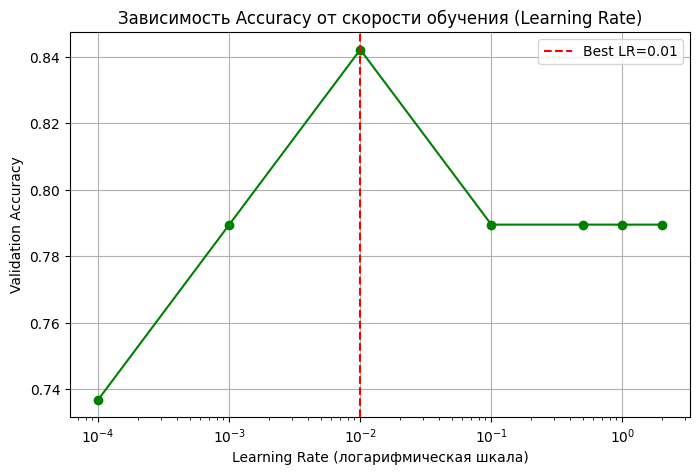

Лучший Learning Rate: 0.01
>>> Запуск Логистической регрессии


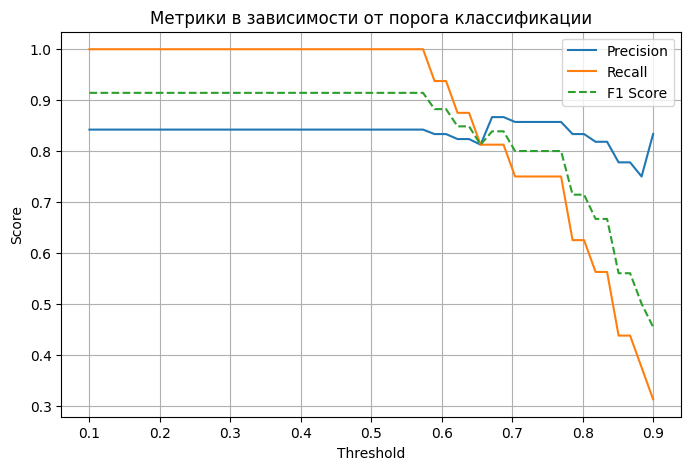

Лучший порог (по max F1 на валидации): 0.10
--- Logistic Regression ---
Accuracy:  0.8000
Precision: 0.8000
Recall:    1.0000
ROC-AUC:   0.4844


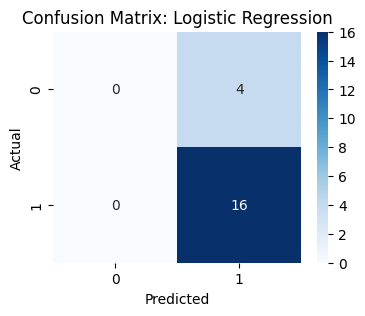

In [90]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)
        roc = roc_auc_score(y_test, y_proba)
    except AttributeError:
        roc = 0.5

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)

    print(f"--- {model_name} ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print("\n")

print(">>> Запуск Тривиального классификатора")
triv_model = TrivialClassifier()
triv_model.fit(y_train)
evaluate_model(triv_model, X_test, y_test, "Trivial Classifier")

print(">>> Запуск Наивного Байеса")
nb_model = CustomNaiveBayes()
nb_model.fit(X_train, y_train)
evaluate_model(nb_model, X_test, y_test, "Naive Bayes")

print(">>> Запуск k-NN с подбором k")
best_k = 1
best_acc = 0
k_values = range(1, 21)

for k in k_values:
    knn = CustomKNN(k=k)
    knn.fit(X_train, y_train)
    acc = accuracy_score(y_val, knn.predict(X_val))
    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"Оптимальный k: {best_k}")
knn_best = CustomKNN(k=best_k)
knn_best.fit(X_train, y_train)
evaluate_model(knn_best, X_test, y_test, f"k-NN (k={best_k})")


print(">>> Запуск Логистической регрессии с подбором Learning Rate")

learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0]
val_accuracies_lr = []
best_lr = 0.01
best_acc_lr = 0

for lr in learning_rates:
    lr_model_temp = CustomLogisticRegression(lr=lr, n_iters=2000)
    lr_model_temp.fit(X_train, y_train)

    preds = lr_model_temp.predict(X_val)
    acc = accuracy_score(y_val, preds)
    val_accuracies_lr.append(acc)

    if acc >= best_acc_lr:
        best_acc_lr = acc
        best_lr = lr

plt.figure(figsize=(8, 5))
plt.semilogx(learning_rates, val_accuracies_lr, marker='o', linestyle='-', color='g')
plt.title('Зависимость Accuracy от скорости обучения (Learning Rate)')
plt.xlabel('Learning Rate (логарифмическая шкала)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.axvline(x=best_lr, color='r', linestyle='--', label=f'Best LR={best_lr}')
plt.legend()
plt.show()

print(f"Лучший Learning Rate: {best_lr}")

print(">>> Запуск Логистической регрессии")
lr_model = CustomLogisticRegression(lr=best_lr, n_iters=2000)
lr_model.fit(X_train, y_train)

y_val_probs = lr_model.predict_proba(X_val)

thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    preds = [1 if p > t else 0 for p in y_val_probs]
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score(y_val, preds, zero_division=0))
    f1_scores.append(f1_score(y_val, preds, zero_division=0))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Метрики в зависимости от порога классификации')
plt.legend()
plt.grid(True)
plt.show()

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
print(f"Лучший порог (по max F1 на валидации): {best_threshold:.2f}")

lr_model.set_threshold(best_threshold)
evaluate_model(lr_model, X_test, y_test, "Logistic Regression")